In [19]:
# Скачиваем картинки с GoogleDrive
!pip install gdown --quiet
!gdown 1QOMiq9_7zYjsWTJ54kA1a8P7QO2T7MiM

Downloading...
From (original): https://drive.google.com/uc?id=1QOMiq9_7zYjsWTJ54kA1a8P7QO2T7MiM
From (redirected): https://drive.google.com/uc?id=1QOMiq9_7zYjsWTJ54kA1a8P7QO2T7MiM&confirm=t&uuid=0fc6a6fe-254b-4c48-9518-46fd84bd24fd
To: /kaggle/working/aaa_advml_final_project_images.zip
100%|██████████████████████████████████████| 3.25G/3.25G [02:07<00:00, 25.6MB/s]


In [21]:
# Распаковываем архив
!unzip /kaggle/working/aaa_advml_final_project_images.zip -d /kaggle/working/images/ > /dev/null

In [22]:
# Удаляем архив
!rm /kaggle/working/aaa_advml_final_project_images.zipaz1zio33.part
!rm /kaggle/working/aaa_advml_final_project_images.zip

rm: cannot remove '/kaggle/working/aaa_advml_final_project_images.zipaz1zio33.part': No such file or directory


In [4]:
!pip3 install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00:00:0100:01


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/aaa-project/aaa_advml_final_project.csv')

In [2]:
categories = df['category_name'].unique()
subcategories = df['subcategory_name'].unique()
num_categories = len(df['category_name'].unique())
num_subcategories = len(df['subcategory_name'].unique())

print(categories, subcategories, num_categories, num_subcategories)

['Электроника' 'Личные вещи'] ['Телефоны' 'Красота и здоровье' 'Товары для детей и игрушки'
 'Одежда, обувь, аксессуары' 'Детская одежда и обувь'
 'Настольные компьютеры' 'Игры, приставки и программы' 'Ноутбуки'
 'Часы и украшения' 'Аудио и видео' 'Товары для компьютера'
 'Оргтехника и расходники' 'Фототехника' 'Планшеты и электронные книги'] 2 14


### Очистка данных

In [6]:
# Удаляем выбросы и невозможные значения цены
df = df[(df['price'] <= 1e6) & (df['price'] > 0)]

### Выбор подхода
Основной подход идейно схож с теми, что использовались в статьях ниже:
- https://arxiv.org/pdf/2012.06008
- https://arxiv.org/pdf/2102.04674

In [9]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import DistilBertModel, DistilBertTokenizer, BertModel
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split


class PricePredictor(nn.Module):
    def __init__(self, image_embedding_dim=512, text_embedding_dim=512, hidden_dim=256, num_categories=100, num_subcategories=500):
        super().__init__()

        # Image encoder
        self.image_encoder = timm.create_model('convnext_base', num_classes=0, pretrained=True)
        self.image_proj = nn.Linear(1024, image_embedding_dim)

        # Text encoder
        self.text_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_proj = nn.Linear(768, text_embedding_dim)

        # Category Embeddings
        self.category_emb = nn.Embedding(num_categories, 128)
        self.subcategory_emb = nn.Embedding(num_subcategories, 128)

        # Final head
        total_input_dim = image_embedding_dim + text_embedding_dim + 128 + 128
        self.mlp = nn.Sequential(
            nn.Linear(total_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image, input_ids, attention_mask, category_ids, subcategory_ids):
        # Image branch
        img_feat = self.image_encoder(image)
        img_emb = self.image_proj(img_feat)

        # Text branch
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_proj(text_out.last_hidden_state[:, 0])

        # Category embeddings
        cat_emb = self.category_emb(category_ids)
        subcat_emb = self.subcategory_emb(subcategory_ids)

        # Concatenate all features
        fused = torch.cat([img_emb, text_emb, cat_emb, subcat_emb], dim=1)
        price = self.mlp(fused)

        return price


class ProductDataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, transform, max_len=128):
        self.df = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

        # Map categories to indices
        self.category_to_idx = {c: i for i, c in enumerate(dataframe['category_name'].unique())}
        self.subcategory_to_idx = {c: i for i, c in enumerate(dataframe['subcategory_name'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, str(row['image_id']) + '.jpg')
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        text = f"{row['title']}" # Пробовали прокидывать description
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        price = max(float(row['price']), 0.0)
        price = torch.tensor(np.log1p(price), dtype=torch.float32)

        category_id = self.category_to_idx[row['category_name']]
        subcategory_id = self.subcategory_to_idx[row['subcategory_name']]

        return image, input_ids, attention_mask, price, category_id, subcategory_id

2025-06-06 11:27:14.794788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749209234.982762      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749209235.043667      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*Замечание:* предполагается, что df уже очищен и содержит лишь релевантные данные.

### Настройка валидации
Нужно ли отделять трейн от теста по времени? В нашем случае, нет.

Одинаковое ли распределение ответов валидационной выборки и потока в продакшн? Да, вполне, так как выгрузка делалась из прода, а валидация формировалась с помощью стратификации из выгрузки.

Нет ли в обучении утечки целевой переменной в признаки? Нет.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

image_dir = "/kaggle/working/images/aaa_advml_final_project_images"

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['category_name'], random_state=42)

text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),  # Slight blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ProductDataset(train_df, image_dir, text_tokenizer, transform_train)
val_dataset = ProductDataset(val_df, image_dir, text_tokenizer, transform_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

num_categories = len(df['category_name'].unique())
num_subcategories = len(df['subcategory_name'].unique())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

image_dir = "/kaggle/working/images/aaa_advml_final_project_images"

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['category_name'], random_state=42)

text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),  # Slight blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ProductDataset(train_df, image_dir, text_tokenizer, transform_train)
val_dataset = ProductDataset(val_df, image_dir, text_tokenizer, transform_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

num_categories = len(df['category_name'].unique())
num_subcategories = len(df['subcategory_name'].unique())

model = PricePredictor(
    num_categories=num_categories,
    num_subcategories=num_subcategories
).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)  # Custom LR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(5):
    model.train()
    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", total=len(train_loader))
    for images, input_ids, attention_mask, prices, categories, subcategories in pbar:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        prices = prices.to(device).unsqueeze(1)
        categories = categories.to(device)
        subcategories = subcategories.to(device)

        preds = model(images, input_ids, attention_mask, categories, subcategories)
        loss = criterion(preds, prices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    scheduler.step()

    print(f"Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", total=len(val_loader))
        for images, input_ids, attention_mask, prices, categories, subcategories in pbar_val:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            prices = prices.to(device).unsqueeze(1)
            categories = categories.to(device)
            subcategories = subcategories.to(device)

            preds = model(images, input_ids, attention_mask, categories, subcategories)
            loss = criterion(preds, prices)
            val_loss += loss.item()
            pbar_val.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    print(f"Model saved as model_epoch_{epoch+1}.pth")

In [11]:
class CategorySubcategoryDataset(Dataset):
    def __init__(self, df, image_dir, transform):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

        self.category_to_idx = {c: i for i, c in enumerate(df['category_name'].unique())}
        self.subcategory_to_idx = {c: i for i, c in enumerate(df['subcategory_name'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, str(row['image_id']) + '.jpg')
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        category = self.category_to_idx[row['category_name']]
        subcategory = self.subcategory_to_idx[row['subcategory_name']]

        return image, category, subcategory

In [12]:
class CategorySubcategoryClassifier(nn.Module):
    def __init__(self, num_categories, num_subcategories):
        super().__init__()
        self.backbone = timm.create_model('convnext_base', pretrained=True, num_classes=0)
        feat_dim = 1024

        self.category_head = nn.Linear(feat_dim, num_categories)
        self.subcategory_head = nn.Linear(feat_dim, num_subcategories)

    def forward(self, x):
        features = self.backbone(x)
        category_logits = self.category_head(features)
        subcategory_logits = self.subcategory_head(features)
        return category_logits, subcategory_logits

In [13]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import timm
from tqdm import tqdm

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CategorySubcategoryDataset(train_df, image_dir, transform_train)
val_dataset = CategorySubcategoryDataset(val_df, image_dir, transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

num_categories = len(train_dataset.category_to_idx)
num_subcategories = len(train_dataset.subcategory_to_idx)

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import timm
from tqdm import tqdm

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CategorySubcategoryDataset(train_df, image_dir, transform_train)
val_dataset = CategorySubcategoryDataset(val_df, image_dir, transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

num_categories = len(train_dataset.category_to_idx)
num_subcategories = len(train_dataset.subcategory_to_idx)

model = CategorySubcategoryClassifier(num_categories, num_subcategories).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_val_accuracy = 0.0

for epoch in range(5):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", total=len(train_loader))
    
    for images, categories, subcategories in pbar:
        images = images.cuda()
        categories = categories.cuda()
        subcategories = subcategories.cuda()

        cat_logits, subcat_logits = model(images)

        loss_cat = F.cross_entropy(cat_logits, categories)
        loss_subcat = F.cross_entropy(subcat_logits, subcategories)
        loss = loss_cat + loss_subcat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    correct_cat = 0
    correct_subcat = 0
    total = 0

    with torch.no_grad():
        for images, categories, subcategories in val_loader:
            images = images.cuda()
            categories = categories.cuda()
            subcategories = subcategories.cuda()

            cat_logits, subcat_logits = model(images)

            _, predicted_cat = torch.max(cat_logits, dim=1)
            _, predicted_subcat = torch.max(subcat_logits, dim=1)

            correct_cat += (predicted_cat == categories).sum().item()
            correct_subcat += (predicted_subcat == subcategories).sum().item()
            total += categories.size(0)

        acc_cat = correct_cat / total
        acc_subcat = correct_subcat / total
        combined_acc = (acc_cat + acc_subcat) / 2

    print(f"Validation Accuracy - Category: {acc_cat:.4f}, Subcategory: {acc_subcat:.4f}, Combined: {combined_acc:.4f}")

    if combined_acc > best_val_accuracy:
        best_val_accuracy = combined_acc
        torch.save(model.state_dict(), 'best_cat_model.pth')
        print(f"Best model saved with combined accuracy: {best_val_accuracy:.4f}")

In [14]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, DistilBertTokenizer

dataset = CategorySubcategoryDataset(df, image_dir, transform_train)

def full_inference_pipeline(image_path, device="cuda"):
    """
    Predicts price based only on input image.
    
    Pipeline:
        1. Predict category & subcategory
        2. Generate title with BLIP
        3. Predict price using full model
    """
    category_model.eval()
    price_model.eval()
    blip_model.eval()
    
    image = Image.open(image_path).convert("RGB")
    raw_image_tensor = transform_val(image).unsqueeze(0).to(device)  # For classification

    with torch.no_grad():
        cat_logits, subcat_logits = category_model(raw_image_tensor)
    predicted_cat_id = cat_logits.argmax().item()
    predicted_subcat_id = subcat_logits.argmax().item()

    idx_to_category = {v: k for k, v in dataset.category_to_idx.items()}
    idx_to_subcategory = {v: k for k, v in dataset.subcategory_to_idx.items()}

    predicted_category = idx_to_category[predicted_cat_id]
    predicted_subcategory = idx_to_subcategory[predicted_subcat_id]
    
    inputs = blip_processor(image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    generated_title = blip_processor.decode(out[0], skip_special_tokens=True)

    encoding = tokenizer(
        generated_title,
        padding='max_length',
        truncation=True,
        max_length=128, # or 64?
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    image_tensor = transform_price(image).unsqueeze(0).to(device)

    cat_tensor = torch.tensor([predicted_cat_id], dtype=torch.long).to(device)
    subcat_tensor = torch.tensor([predicted_subcat_id], dtype=torch.long).to(device)

    with torch.no_grad():
        price_log = price_model(
            image_tensor,
            input_ids,
            attention_mask,
            cat_tensor,
            subcat_tensor
        )

    predicted_price = np.expm1(price_log.cpu().item())  # Undo log1p
    return predicted_price, predicted_category, predicted_subcategory, generated_title

In [15]:
from transformers import BlipProcessor, BlipForConditionalGeneration, DistilBertTokenizer
device = 'cuda'

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_price = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

num_categories = len(dataset.category_to_idx)
num_subcategories = len(dataset.subcategory_to_idx)

category_model = CategorySubcategoryClassifier(num_categories, num_subcategories).to(device)
category_model.load_state_dict(torch.load("/kaggle/input/categorical/pytorch/default/1/best_cat_model.pth"))
category_model.eval()

# Load price predictor
price_model = PricePredictor(
    num_categories=num_categories,
    num_subcategories=num_subcategories
).to(device)
price_model.load_state_dict(torch.load("/kaggle/input/best_model/pytorch/default/1/model_epoch_5.pth"))
price_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

PricePredictor(
  (image_encoder): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
         

### Анализ ошибок

In [23]:
# Пример
image_path = "/kaggle/working/images/aaa_advml_final_project_images/43215825272.jpg"
price, category, subcategory, title = full_inference_pipeline(image_path)

print(f"\nFinal Prediction:")
print(f"Category: {category}")
print(f"Subcategory: {subcategory}")
print(f"Title: {title}")
print(f"Predicted Price: {price:.2f} RUB")


Final Prediction:
Category: Электроника
Subcategory: Телефоны
Title: apple iphone x 64gb
Predicted Price: 5873.15 RUB


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd

image_ids = []
predicted_prices = []
actual_prices = []
differences = []

for image_id in tqdm(val_df['image_id'], desc="Processing Images", unit="image", total=len(val_df)):
    image_path = f"/kaggle/working/images/aaa_advml_final_project_images/{image_id}.jpg"
    
    price, category, subcategory, title = full_inference_pipeline(image_path)
    
    actual_price = val_df[val_df['image_id'] == image_id]['price'].values[0]
    
    image_ids.append(image_id)
    predicted_prices.append(price)
    actual_prices.append(actual_price)
    differences.append(abs(price - actual_price))

results_df = pd.DataFrame({
    'image_id': image_ids,
    'predicted_price': predicted_prices,
    'actual_price': actual_prices,
    'difference': differences
})

results_df['squared_error'] = (results_df['predicted_price'] - results_df['actual_price']) ** 2
results_df['abs_percentage_error'] = abs((results_df['predicted_price'] - results_df['actual_price']) / results_df['actual_price'])
new_results_df = results_df

In [31]:
mse = new_results_df['squared_error'].mean()
mae = new_results_df['difference'].mean()
mape = new_results_df['abs_percentage_error'].mean() * 100 

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

top_10_diff = new_results_df.sort_values(by='difference', ascending=False).head(10)
print("\nTop 10 items with largest prediction difference:")
print(top_10_diff[['image_id', 'actual_price', 'predicted_price', 'difference']])

MSE: 429736064.93
MAE: 6864.75
MAPE: 45.27%

Top 10 items with largest prediction difference:
         image_id  actual_price  predicted_price     difference
7591  43871888458      435561.0     97616.444681  337944.555319
6554  43872330980      398339.0     65752.236247  332586.763753
4589  43873159987      314082.0     29668.346348  284413.653652
7644  43609468452      290000.0      6573.743399  283426.256601
3807  43754753955      282000.0       846.354239  281153.645761
103   43855815204      415900.0    138414.930091  277485.069909
7914  43863845565      277000.0      3459.280977  273540.719023
5101  43858117156      343500.0     70513.944199  272986.055801
7543  43872386587      271099.0      7489.154899  263609.845101
8509  43857154388      275000.0     27695.626426  247304.373574


In [61]:
top_10_diff.merge(right=val_df[['image_id', 'category_name', 'subcategory_name']], how='left', on='image_id')

,image_id,predicted_price,actual_price,difference,squared_error,abs_percentage_error,category_name,subcategory_name
0,43871888458,97616.537777,435561.0,337944.462223,1.142065e+11,0.775883,Личные вещи,Часы и украшения
1,43872330980,65752.236247,398339.0,332586.763753,1.106140e+11,0.834934,Личные вещи,Часы и украшения
2,43873159987,29668.374643,314082.0,284413.625357,8.089111e+10,0.905539,Личные вещи,Часы и украшения
3,43609468452,6573.749669,290000.0,283426.250331,8.033044e+10,0.977332,Личные вещи,"Одежда, обувь, аксессуары"
4,43754753955,846.354239,282000.0,281153.645761,7.904737e+10,0.996999,Личные вещи,Часы и украшения
5,43855815204,138415.062095,415900.0,277484.937905,7.699789e+10,0.667191,Электроника,Ноутбуки
6,43863845565,3459.280977,277000.0,273540.719023,7.482452e+10,0.987512,Личные вещи,Часы и украшения
7,43858117156,70513.944199,343500.0,272986.055801,7.452139e+10,0.794719,Электроника,Аудио и видео
8,43872386587,7489.154899,271099.0,263609.845101,6.949015e+10,0.972375,Личные вещи,Часы и украшения
9,43857154388,27695.626426,275000.0,247304.373574,6.115945e+10,0.899289,Электроника,Настольные компьютеры


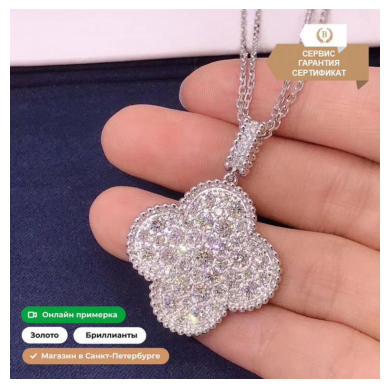

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

img_id = 43871888458
image_path = f"/kaggle/working/images/aaa_advml_final_project_images/{img_id}.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
top_100_diff = new_results_df.sort_values(by='difference', ascending=False).head(100)

In [37]:
top_100_diff = top_100_diff.merge(right=val_df[['image_id', 'category_name', 'subcategory_name']], how='left', on='image_id')

In [39]:
top_100_diff['subcategory_name'].value_counts()

subcategory_name
Ноутбуки                        18
Часы и украшения                15
Настольные компьютеры           13
Одежда, обувь, аксессуары        9
Фототехника                      8
Товары для детей и игрушки       8
Телефоны                         8
Аудио и видео                    7
Красота и здоровье               5
Планшеты и электронные книги     4
Товары для компьютера            3
Оргтехника и расходники          2
Name: count, dtype: int64

In [40]:
top_10_diff.merge(right=val_df[['image_id', 'category_name', 'subcategory_name']], how='left', on='image_id')['subcategory_name'].value_counts()

subcategory_name
Часы и украшения             6
Одежда, обувь, аксессуары    1
Ноутбуки                     1
Аудио и видео                1
Настольные компьютеры        1
Name: count, dtype: int64

### Вывод:
Самые большие ошибки в подкатегории **"Часы и украшения"** наблюдаются по нескольким ключевым причинам:
1. Широкий разброс цен
2. Субъективная ценность (то есть модель не может оценить раритетность/винтажность вещи)